In [ ]:
project_root = os.getcwd()
model_dir = os.path.join(project_root, 'checkpoints')
model_path = os.path.join(model_dir, 'vgg16-model-35-progress-report.hdf5')
runTestFinalReport(model_path)

# CNN Final Reports

In [ ]:
from model.cnn_model import *

In [2]:
def TrainModelFinalReport(model, dataset='train', checkpoint_name_prefix = 'model', from_epoch=0, use_validation=True, use_augmentation=False, use_limited_augmentation=False):
    project_root = os.getcwd()
    
    checkpoint_name = checkpoint_name_prefix + '-{epoch:02d}.hdf5'

    checkpoints_dir = os.path.join('/media', 'exfat', 'cs221-project', 'checkpoints', checkpoint_name)
    checkpoint = ModelCheckpoint(checkpoints_dir, monitor='val_acc', verbose=1, period=5)

    tensorboard_dir = os.path.join(project_root, 'logs')
    tensorboard = TensorBoard(tensorboard_dir)

    if from_epoch > 0:
        model_path = os.path.join(project_root, 'checkpoints', checkpoint_name.format(epoch=from_epoch))
        model = load_model(model_path, custom_objects={'tf': tf})
        initial_epoch = from_epoch
    else:
        # annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))
        # sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.categorical_accuracy])
        initial_epoch = 0

    # ------------------------------------------------------------------------------------------------------- #

    image_dir = os.path.join(project_root, 'data', dataset)
    augmt_dir = os.path.join(project_root, 'data', '{}_aug_limited'.format(dataset) if use_limited_augmentation else '{}_aug'.format(dataset))

    num_samples = len(list(os.listdir(image_dir)))
    if use_augmentation:
        num_samples += len(list(os.listdir(augmt_dir)))
    
    # annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))

    if use_validation:
        x_input_val, y_input_val = getValidationSetRaw(os.path.join(project_root, 'data', 'valid'))

        h = model.fit_generator(
            trainDataGeneratorRaw(image_dir, augmt_dir, BATCH_SIZE, use_augmentation),
            steps_per_epoch=np.ceil(num_samples / BATCH_SIZE),
            initial_epoch=initial_epoch,
            validation_data=(x_input_val, y_input_val),
            epochs=TOTAL_EPOCH,
            verbose=1,
            callbacks=[checkpoint, tensorboard])

    else:
        h = model.fit_generator(
            trainDataGeneratorRaw(image_dir, augmt_dir, BATCH_SIZE, use_augmentation),
            steps_per_epoch=np.ceil(num_samples / BATCH_SIZE),
            initial_epoch=initial_epoch,
            epochs=TOTAL_EPOCH,
            verbose=1,
            callbacks=[checkpoint, tensorboard])

In [3]:
def createImageModelFromVGG16FinalReport(weights = 'imagenet', pre_trained_model_freeze=None, dense_layers=True, dense_unit=4096):
    # start with a standard vgg network
    pre_trained_model = vgg16.VGG16(weights=weights, include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    if pre_trained_model_freeze is not None:
        print(pre_trained_model.layers[pre_trained_model_freeze])
        for layer in pre_trained_model.layers[:(pre_trained_model_freeze+1)]:
            layer.trainable = False
    x = pre_trained_model.layers[-1].output
    x = Flatten(name='flatten')(x)
    if dense_layers:
        x = Dense(dense_unit, activation='relu', name='fc1')(x)
        x = Dense(dense_unit, activation='relu', name='fc2')(x)
    model_output = Dense(43, activation='softmax')(x)
    img_model = Model(inputs=pre_trained_model.input, outputs=model_output, name="img_model")
    print(img_model.summary())
    return img_model

## VGG-16

In [ ]:
# Default parameters. Using imagenet weights and no freeze.
model = createImageModelFromVGG16FinalReport()
TrainModelFinalReport(model, checkpoint_name_prefix='vgg16-final-report-imagenet-no-freeze')

In [ ]:
for i in [18, 14, 10, 6]:
    """
    6 - block 1 and block 2
    10 - block 1 to 3
    14 - block 1 to 4
    18 - block 1 to 5
    """
    model = createImageModelFromVGG16FinalReport(pre_trained_model_freeze=i)
    checkpoint_name_prefix = 'vgg16-final-report-imagenet-freeze-' + str(i)
    TrainModelFinalReport(model, checkpoint_name_prefix=checkpoint_name_prefix)

In [ ]:
# Default parameters. Using random weights and no freeze.
model = createImageModelFromVGG16FinalReport(weights=None)
TrainModelFinalReport(model, checkpoint_name_prefix='vgg16-final-report-random-no-freeze')

In [ ]:
# Default parameters. Using imagenet weights and no freeze. No dense layers.
model = createImageModelFromVGG16FinalReport(dense_layers=False)
TrainModelFinalReport(model, checkpoint_name_prefix='vgg16-final-report-imagenet-no-freeze-no-dense')

In [ ]:
# Default parameters. Using random weights and no freeze. No dense unit.
model = createImageModelFromVGG16FinalReport(weights=None, dense_layers=False)
TrainModelFinalReport(model, checkpoint_name_prefix='vgg16-final-report-random-no-freeze-no-dense')

In [ ]:
# Default parameters. Using imagenet weights and no freeze. Dense layers 256 units.
model = createImageModelFromVGG16FinalReport(dense_unit=256)
TrainModelFinalReport(model, checkpoint_name_prefix='vgg16-final-report-imagenet-no-freeze-256-dense')

In [ ]:
for i in [18, 14, 10, 6]:
    """
    6 - block 1 and block 2
    10 - block 1 to 3
    14 - block 1 to 4
    18 - block 1 to 5
    """
    model = createImageModelFromVGG16FinalReport(pre_trained_model_freeze=i, dense_layers=False)
    checkpoint_name_prefix = 'vgg16-final-report-imagenet-freeze-no-dense-' + str(i)
    TrainModelFinalReport(model, checkpoint_name_prefix=checkpoint_name_prefix)

In [ ]:
# Default parameters. Using random weights and no freeze. Dense layers 256 units.
model = createImageModelFromVGG16FinalReport(weights=None, dense_unit=256)
TrainModelFinalReport(model, checkpoint_name_prefix='vgg16-final-report-random-no-freeze-256-dense')

In [ ]:
# Default parameters. Using random weights and no freeze. Dense layers n units.
for n in [32]:
    model = createImageModelFromVGG16FinalReport(weights='imagenet', dense_unit=n)
    TrainModelFinalReport(model, checkpoint_name_prefix='vgg16-final-report-imagenet-no-freeze-dense-' + str(n))

In [ ]:
# Default parameters. Using random weights and no freeze. Dense layers n units.
for n in [64, 128]:
    model = createImageModelFromVGG16FinalReport(weights='imagenet', dense_unit=n)
    TrainModelFinalReport(model, checkpoint_name_prefix='vgg16-final-report-imagenet-no-freeze-dense-' + str(n))

## ResNet50

In [4]:
def createImageModelFromResnetFinalReport(weights = 'imagenet', pre_trained_model_freeze=None):
    # start with a standard ResNet50 network
    pre_trained_model = resnet50.ResNet50(weights=weights, include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    if pre_trained_model_freeze is not None:
        for layer in pre_trained_model.layers:
            if layer.name == pre_trained_model_freeze:
                print(layer.name)
                break
            layer.trainable = False
    # add trainable FC layers
    x = pre_trained_model.layers[-1].output
    x = GlobalAveragePooling2D()(x)
    model_output = Dense(43, activation='softmax')(x)
    img_model = Model(inputs=pre_trained_model.input, outputs=model_output, name="img_model")
    print(img_model.summary())
    return img_model

In [ ]:
# Default parameters. Using random weights and no freeze.
model = createImageModelFromResnetFinalReport(weights=None)
TrainModelFinalReport(model, checkpoint_name_prefix='resnet-final-report-random-no-freeze')

In [13]:
model = createImageModelFromResnetFinalReport()
TrainModelFinalReport(model, checkpoint_name_prefix='resnet-final-report-imagenet-no-freeze-full-aug', use_augmentation=True)

/home/ken/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "img_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________



Epoch 1/30
605/605 [==============================] - 158s 261ms/step - loss: 0.1318 - categorical_accuracy: 0.9645 - val_loss: 0.2300 - val_categorical_accuracy: 0.9475

Epoch 2/30
605/605 [==============================] - 134s 221ms/step - loss: 0.0198 - categorical_accuracy: 0.9944 - val_loss: 0.3166 - val_categorical_accuracy: 0.9130
Epoch 3/30
605/605 [==============================] - 134s 222ms/step - loss: 0.0156 - categorical_accuracy: 0.9956 - val_loss: 0.1899 - val_categorical_accuracy: 0.9536
Epoch 4/30
605/605 [==============================] - 134s 222ms/step - loss: 0.0432 - categorical_accuracy: 0.9904 - val_loss: 0.3982 - val_categorical_accuracy: 0.9235
Epoch 5/30
605/605 [==============================] - 134s 222ms/step - loss: 0.0079 - categorical_accuracy: 0.9979 - val_loss: 0.2051 - val_categorical_accuracy: 0.9428

Epoch 00005: saving model to /media/exfat/cs221-project/checkpoints/resnet-final-report-imagenet-no-freeze-full-aug-05.hdf5
Epoch 6/30
605/605 [==

In [ ]:
for layer_name in ["res2a_branch2a", "res3a_branch2a", "res4a_branch2a", "res5a_branch2a", "global_average_pooling2d_2"]:
    model = createImageModelFromResnetFinalReport(pre_trained_model_freeze=layer_name)
    checkpoint_name_prefix = 'resnet-final-report-imagenet-freeze-no-dense-' + layer_name
    TrainModelFinalReport(model, checkpoint_name_prefix=checkpoint_name_prefix)

## DenseNet

In [5]:
def createDenseModelFinalReport(weights='imagenet'):
    pre_trained_model = densenet.DenseNet121(weights=weights, include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    x = pre_trained_model.layers[-1].output
    x = GlobalAveragePooling2D()(x)
    model_output = Dense(43, activation='softmax')(x)
    img_model = Model(inputs=pre_trained_model.input, outputs=model_output, name="img_model")
    print(img_model.summary())
    return img_model

In [ ]:
TOTAL_EPOCH = 30
model = createDenseModelFinalReport()
TrainModelFinalReport(model, checkpoint_name_prefix='desnet-final-report-imagenet-30-epoch')

In [ ]:
TOTAL_EPOCH = 50
model = createDenseModelFinalReport()
TrainModelFinalReport(model, checkpoint_name_prefix='desnet-final-report-imagenet-50-epoch')
TOTAL_EPOCH = 30 # setting it back

In [ ]:
model = createDenseModelFinalReport(weights=None)
TrainModelFinalReport(model, checkpoint_name_prefix='desnet-final-report-random-30-epoch')

In [ ]:
model = createDenseModelFinalReport()
TrainModelFinalReport(model, checkpoint_name_prefix='desnet-final-report-imagenet-full-aug-30-epoch', use_augmentation=True)

In [ ]:
TOTAL_EPOCH = 50
model = createDenseModelFinalReport(weights=None)
TrainModelFinalReport(model, checkpoint_name_prefix='desnet-final-report-random-50-epoch')
TOTAL_EPOCH = 30 # setting it back

In [ ]:
TOTAL_EPOCH = 50
model = createDenseModelFinalReport()
TrainModelFinalReport(model, checkpoint_name_prefix='desnet-final-report-imagenet-full-aug-50-epoch', use_augmentation=True)
TOTAL_EPOCH = 30 # setting it back

In [ ]:
TestModel(os.path.join(os.getcwd(), 'checkpoints', 'final-dense-2-0.9935.hdf5'))

# Error Analysis

In [6]:
def ErrorAnalysisFinalReport(analysis_path, image_name, image_dir, label, prediction):
    new_name = '{}_|_{}_|_{}'.format(prediction, label, image_name)
    source_path = os.path.join(image_dir, image_name)
    destination_path = os.path.join(analysis_path, new_name)
    shutil.copyfile(source_path, destination_path)


def ErrorStatisticsFinalReport(y_true, y_pred):
    tally = {}
    for i in range(len(y_true)):
        label, pred = y_true[i], y_pred[i]
        if label not in tally:
            tally[label] = collections.defaultdict(int)
        tally[label][pred] += 1

    for label, perf in sorted(tally.items(), key=lambda item: item[0]):
        to_print = 'Sign {} mispredicted as'.format(label)
        should_print = False
        correct, mispredicted = 0, 0
        for pred, count in sorted(perf.items(), key=lambda item: item[1], reverse=True):
            if label != pred and count != 0:
                to_print += ' ({}: {}) '.format(pred, count)
                should_print = True
                mispredicted += count
            else:
                correct += count
        if should_print:
            to_print += 'accuracy is {} with {}/{}'.format(correct/(correct+mispredicted), correct, correct+mispredicted)
            print(to_print)


def TestModelFinalReport(model_path, analysis_path=None):
    if os.path.exists(model_path):
        model = load_model(model_path)

    project_root = os.getcwd()
    image_dir = os.path.join(project_root, 'data', 'test')
    all_images = list(os.listdir(image_dir))
    num_samples = len(all_images)

    labels = ReadLabelFromCSV(os.path.join(project_root, 'data', 'GT-final_test.csv'))
    y_true = [labels[image] for image in all_images]

    # # generator test
    # x = testDataGeneratorRaw(image_dir, all_images, BATCH_SIZE)
    # first_batch = next(x)
    # print(first_batch[0][22])

    y_pred = model.predict_generator(testDataGeneratorRaw(image_dir, all_images, BATCH_SIZE), steps=np.ceil(num_samples / BATCH_SIZE))
    y_pred = np.argmax(y_pred, axis=1)

    match_cnt = 0
    # key - y_true, value - {key - y_pred, value-index}
    y_error_dict = collections.defaultdict(lambda : collections.defaultdict(list))
    y_true_dict = collections.defaultdict(list)
    for i in range(num_samples):
        if y_true[i] == y_pred[i]:
            match_cnt += 1
            y_true_dict[y_true[i]].append(i)
        else:
            y_error_dict[y_true[i]][y_pred[i]].append(i)
            if analysis_path:
                ErrorAnalysisFinalReport(analysis_path, all_images[i], image_dir, y_true[i], y_pred[i])

    accuracy = match_cnt / num_samples
    print('Accuracy: {}'.format(accuracy))
    ErrorStatisticsFinalReport(y_true, y_pred)
    print(confusion_matrix(y_true, y_pred))
    return y_error_dict, y_true_dict, y_pred, y_true

In [ ]:
y_error_dict_dense, y_true_dict_dense, _ , _ = TestModelFinalReport(os.path.join(os.getcwd(), 'checkpoints', 'final-dense-2-0.9935.hdf5'), os.path.join(os.getcwd(), 'error_analysis'))

In [ ]:
y_error_dict_dense_aug, y_true_dict_dense_aug , _ , _ = TestModelFinalReport(os.path.join(os.getcwd(), 'checkpoints', 'final-dense-3-aug-0.9889.hdf5'), os.path.join(os.getcwd(), 'error_analysis_aug'))

In [7]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

import matplotlib.pyplot as plt
%matplotlib inline

def visualizeSaliencyFinalReport(model_path, class_idx, seed_input, grads=None):
    model = load_model(model_path)
    # Swap softmax with linear, by design for visualization purpose
#     model.layers[-1].activation = activations.linear
#     model = utils.apply_modifications(model)
    # Use -1 for the final layer lay_idx
    if grads is None:
        grads = visualize_saliency(model, -1, filter_indices=class_idx, seed_input=seed_input)
    # grads = visualize_activation(model, -1, filter_indices=class_idx, seed_input=seed_input, verbose=True)
    plt.imshow(grads, cmap='jet')
    plt.axis('off')
    plt.show()
    return grads

In [8]:
def testDataGeneratorRawFinalReport(image_dir):
    all_images = list(os.listdir(image_dir))
    num_examples = len(all_images)
    images = []
    images_raw = []
    for index in range(num_examples):
        img_path = os.path.join(image_dir, all_images[index])
        images.append(getImageTensor(img_path))
        images_raw.append(plt.imread(img_path))
    return np.array(images), images_raw

In [9]:
project_root = os.getcwd()
image_dir = os.path.join(project_root, 'data', 'test')
x_inputs, x_inputs_raw = testDataGeneratorRawFinalReport(image_dir)

In [10]:
%matplotlib inline

def generateSaliencyFinalReport(model_path, save_prefix, interested_classes):
    y_true_saliency = {}
    y_pred_saliency = {}
    
    y_true_saliency_path = save_prefix + 'y_true_saliency.pickle'
    y_pred_saliency_path = save_prefix + 'y_pred_saliency.pickle'

    if os.path.exists(y_true_saliency_path):
        with open(y_true_saliency_path, 'rb') as handle:
            y_true_saliency = pickle.load(handle)

    if os.path.exists(y_pred_saliency_path):
        with open(y_pred_saliency_path, 'rb') as handle:
            y_pred_saliency = pickle.load(handle)

    y_error_dict_dense, y_true_dict, _, _ = TestModelFinalReport(model_path, os.path.join(os.getcwd(), 'error_analysis'))
    for y_true, preds in y_error_dict_dense.items():
        if y_true not in interested_classes:
            continue
        for y_pred, indices in preds.items():
            print("Sign class %d misinterpreted as %d" % (y_true, y_pred))
            # visualize the test image with the wrong predition
            plt.imshow(x_inputs_raw[indices[0]])
            plt.axis('off')
            plt.show()
            # visualize the predicted label using the same test image
            if y_pred in y_pred_saliency:
                visualizeSaliencyFinalReport(model_path, y_pred, x_inputs[indices[0]], y_pred_saliency[y_pred])
            else:
                y_pred_saliency[y_pred] = visualizeSaliencyFinalReport(model_path, y_pred, x_inputs[indices[0]])


            # visualize the true test image with the same predition
            print("Sign class %d correctly interpreted as %d" % (y_pred, y_pred))
            true_pred_class_img = x_inputs[y_true_dict[y_pred][0]]
            true_pred_class_raw = x_inputs_raw[y_true_dict[y_pred][0]]
            plt.imshow(true_pred_class_raw)
            plt.axis('off')
            plt.show()
            
            if y_pred in y_true_saliency:
                visualizeSaliencyFinalReport(model_path, y_pred, true_pred_class_img, y_true_saliency[y_pred])
            else:
                y_true_saliency[y_pred] = visualizeSaliencyFinalReport(model_path, y_pred, true_pred_class_img)
                
            # visualize the true lable using true test image
            print("Sign class %d correctly interpreted as %d" % (y_true, y_true))
            true_label_class_img = x_inputs[y_true_dict[y_true][0]]
            true_label_class_raw = x_inputs_raw[y_true_dict[y_true][0]]
            plt.imshow(true_label_class_raw)
            plt.axis('off')
            plt.show()
            
            if y_true in y_true_saliency:
                visualizeSaliencyFinalReport(model_path, y_true, true_label_class_img, y_true_saliency[y_true])
            else:
                y_true_saliency[y_true] = visualizeSaliencyFinalReport(model_path, y_true, true_label_class_img)
                
            # save variables
            with open(save_prefix + 'y_true_saliency.pickle', 'wb') as handle:
                pickle.dump(y_true_saliency, handle, protocol=pickle.HIGHEST_PROTOCOL)
            with open(save_prefix + 'y_pred_saliency.pickle', 'wb') as handle:
                pickle.dump(y_pred_saliency, handle, protocol=pickle.HIGHEST_PROTOCOL)




Accuracy: 0.9935075217735551
Sign 2 mispredicted as (1: 5) accuracy is 0.9933333333333333 with 745/750
Sign 3 mispredicted as (5: 3)  (42: 1) accuracy is 0.9911111111111112 with 446/450
Sign 4 mispredicted as (20: 1)  (2: 1) accuracy is 0.996969696969697 with 658/660
Sign 5 mispredicted as (1: 1) accuracy is 0.9984126984126984 with 629/630
Sign 6 mispredicted as (42: 3)  (39: 3)  (20: 1) accuracy is 0.9533333333333334 with 143/150
Sign 7 mispredicted as (8: 1) accuracy is 0.9977777777777778 with 449/450
Sign 8 mispredicted as (5: 2) accuracy is 0.9955555555555555 with 448/450
Sign 11 mispredicted as (30: 2)  (20: 1) accuracy is 0.9928571428571429 with 417/420
Sign 12 mispredicted as (38: 3) accuracy is 0.9956521739130435 with 687/690
Sign 13 mispredicted as (41: 1)  (35: 1) accuracy is 0.9972222222222222 with 718/720
Sign 17 mispredicted as (13: 1) accuracy is 0.9972222222222222 with 359/360
Sign 18 mispredicted as (21: 3)  (4: 2)  (10: 1) accuracy is 0.9846153846153847 with 384/390

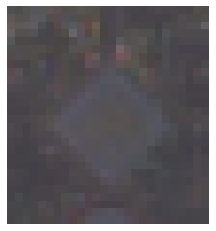

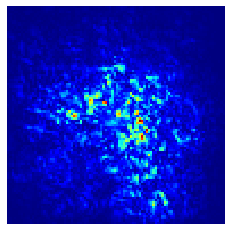

Sign class 38 correctly interpreted as 38


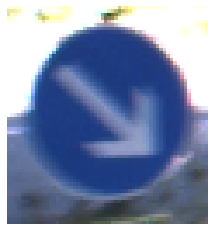

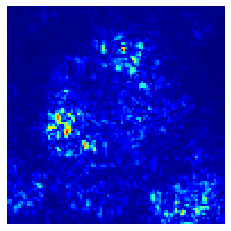

Sign class 12 correctly interpreted as 12


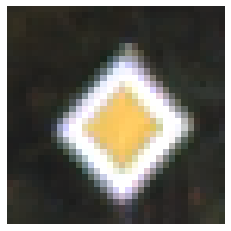

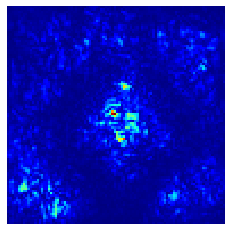

Sign class 4 misinterpreted as 20


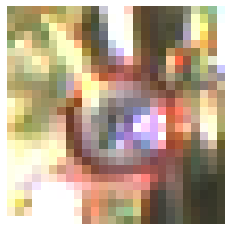

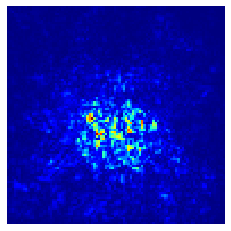

Sign class 20 correctly interpreted as 20


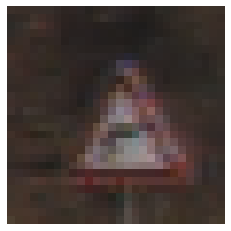

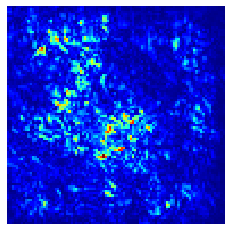

Sign class 4 correctly interpreted as 4


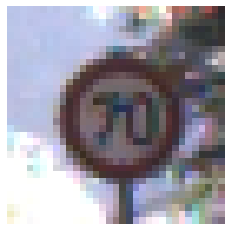

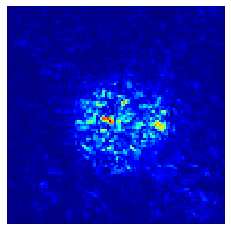

Sign class 4 misinterpreted as 2


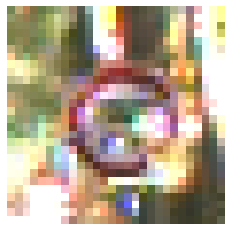

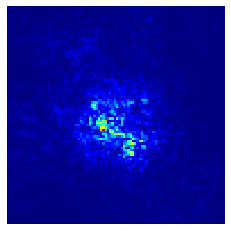

Sign class 2 correctly interpreted as 2


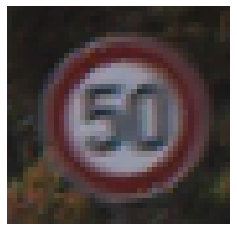

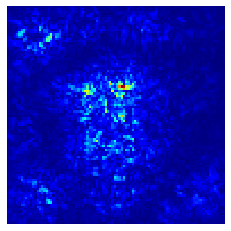

Sign class 4 correctly interpreted as 4


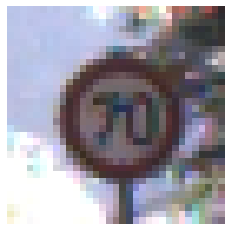

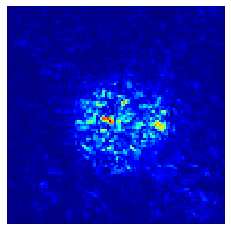

Sign class 18 misinterpreted as 4


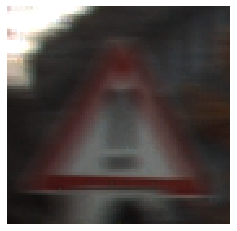

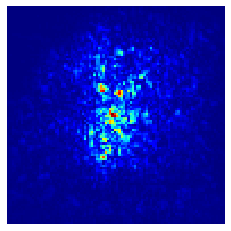

Sign class 4 correctly interpreted as 4


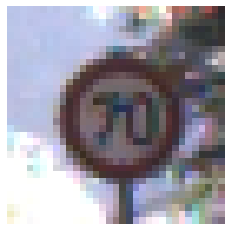

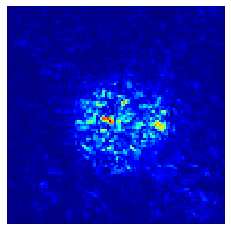

Sign class 18 correctly interpreted as 18


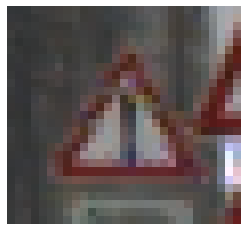

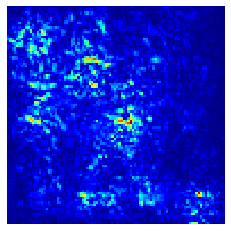

Sign class 18 misinterpreted as 21


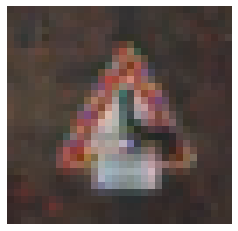

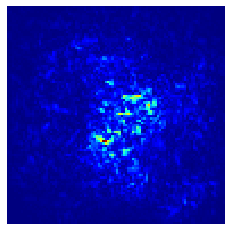

Sign class 21 correctly interpreted as 21


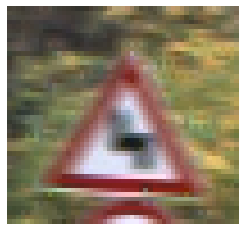

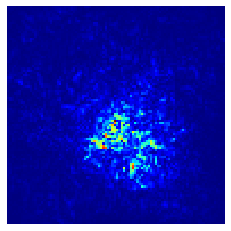

Sign class 18 correctly interpreted as 18


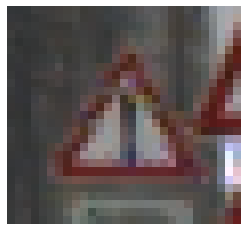

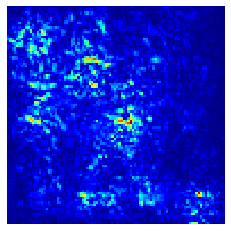

Sign class 18 misinterpreted as 10


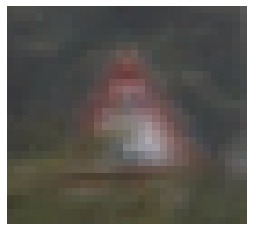

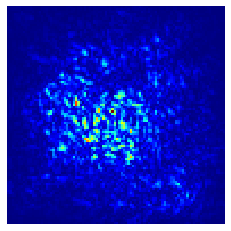

Sign class 10 correctly interpreted as 10


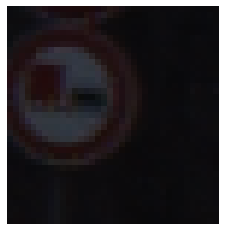

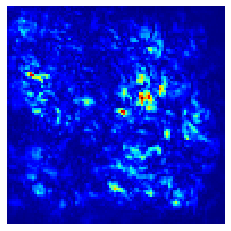

Sign class 18 correctly interpreted as 18


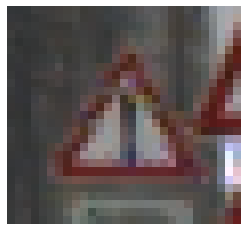

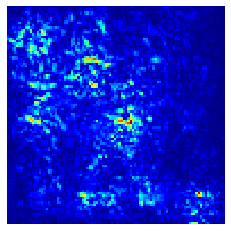

Sign class 25 misinterpreted as 11


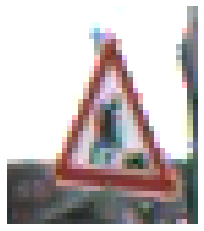

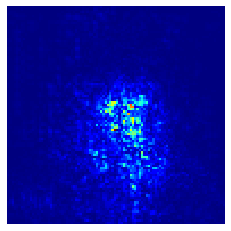

Sign class 11 correctly interpreted as 11


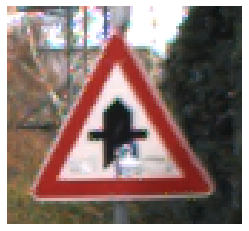

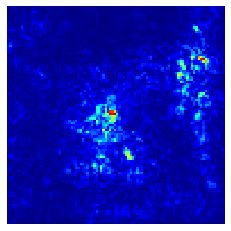

Sign class 25 correctly interpreted as 25


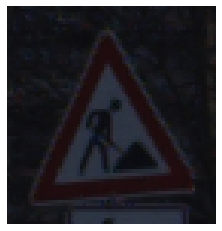

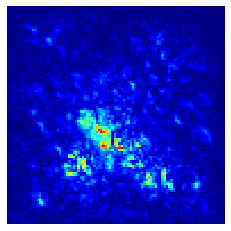

Sign class 25 misinterpreted as 27


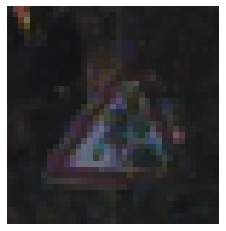

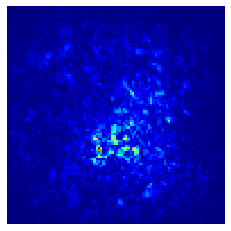

Sign class 27 correctly interpreted as 27


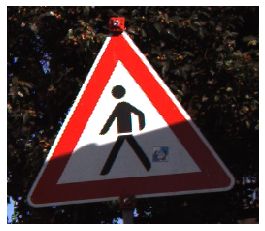

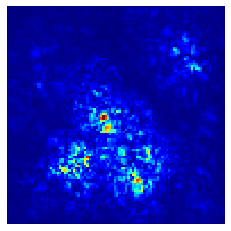

Sign class 25 correctly interpreted as 25


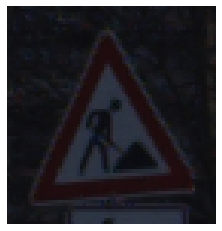

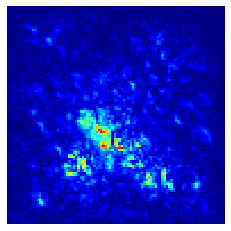

Sign class 25 misinterpreted as 5


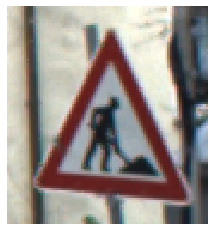

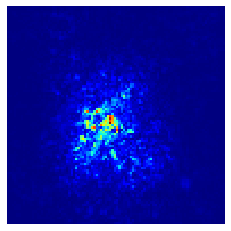

Sign class 5 correctly interpreted as 5


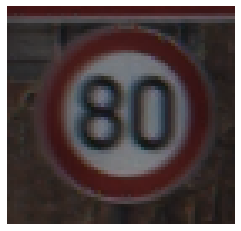

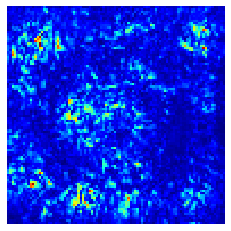

Sign class 25 correctly interpreted as 25


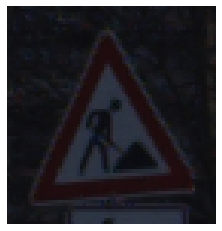

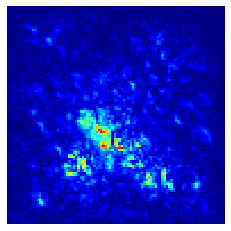

Sign class 40 misinterpreted as 37


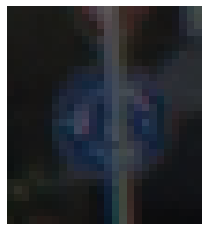

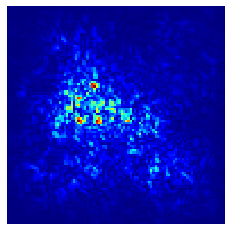

Sign class 37 correctly interpreted as 37


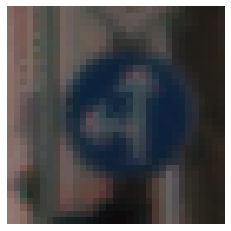

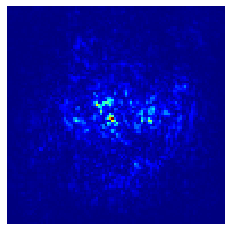

Sign class 40 correctly interpreted as 40


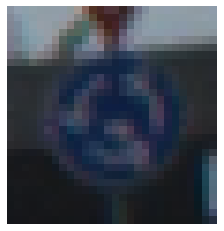

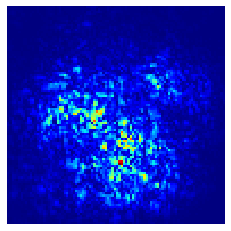

Sign class 40 misinterpreted as 12


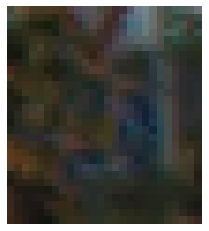

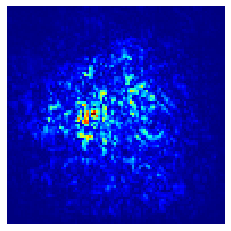

Sign class 12 correctly interpreted as 12


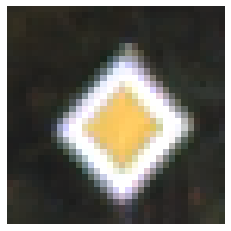

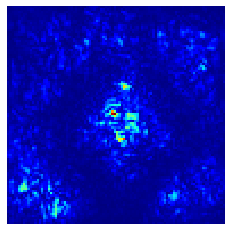

Sign class 40 correctly interpreted as 40


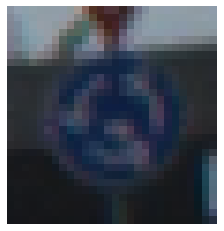

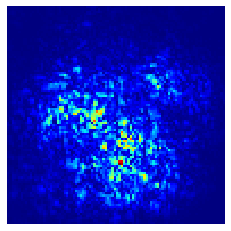

Sign class 27 misinterpreted as 28


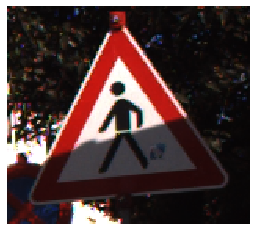

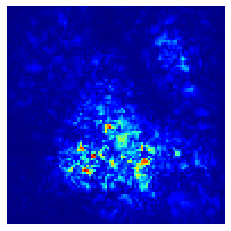

Sign class 28 correctly interpreted as 28


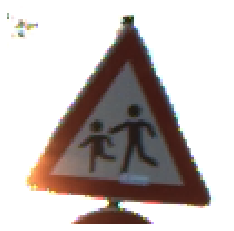

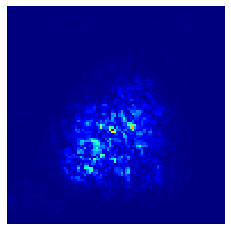

Sign class 27 correctly interpreted as 27


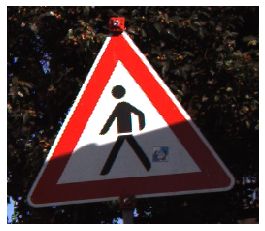

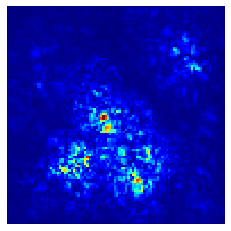

Sign class 27 misinterpreted as 25


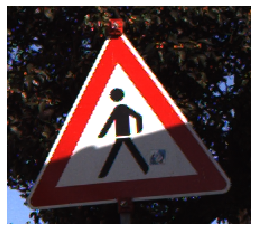

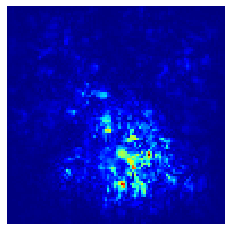

Sign class 25 correctly interpreted as 25


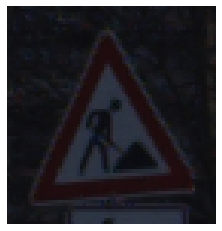

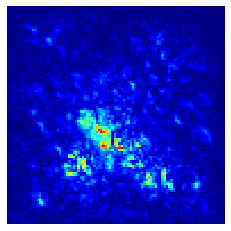

Sign class 27 correctly interpreted as 27


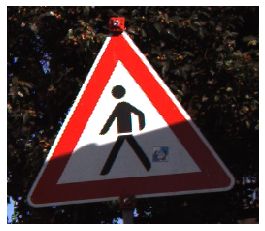

In [ ]:
model_path = os.path.join(os.getcwd(), 'checkpoints', 'final-dense-2-0.9935.hdf5')
interested_classes = [2, 3, 6]
generateSaliencyFinalReport(model_path, "", interested_classes)



Accuracy: 0.9935075217735551
Sign 2 mispredicted as (1: 5) accuracy is 0.9933333333333333 with 745/750
Sign 3 mispredicted as (5: 3)  (42: 1) accuracy is 0.9911111111111112 with 446/450
Sign 4 mispredicted as (20: 1)  (2: 1) accuracy is 0.996969696969697 with 658/660
Sign 5 mispredicted as (1: 1) accuracy is 0.9984126984126984 with 629/630
Sign 6 mispredicted as (42: 3)  (39: 3)  (20: 1) accuracy is 0.9533333333333334 with 143/150
Sign 7 mispredicted as (8: 1) accuracy is 0.9977777777777778 with 449/450
Sign 8 mispredicted as (5: 2) accuracy is 0.9955555555555555 with 448/450
Sign 11 mispredicted as (30: 2)  (20: 1) accuracy is 0.9928571428571429 with 417/420
Sign 12 mispredicted as (38: 3) accuracy is 0.9956521739130435 with 687/690
Sign 13 mispredicted as (41: 1)  (35: 1) accuracy is 0.9972222222222222 with 718/720
Sign 17 mispredicted as (13: 1) accuracy is 0.9972222222222222 with 359/360
Sign 18 mispredicted as (21: 3)  (4: 2)  (10: 1) accuracy is 0.9846153846153847 with 384/390


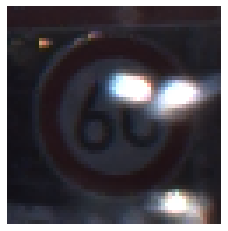

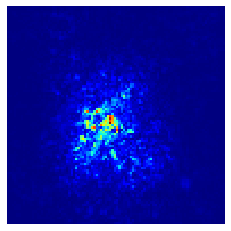

Sign class 5 correctly interpreted as 5


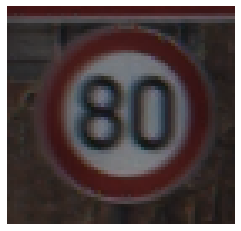

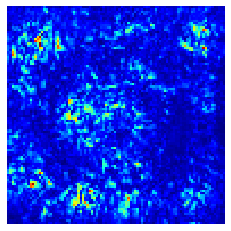

Sign class 3 correctly interpreted as 3


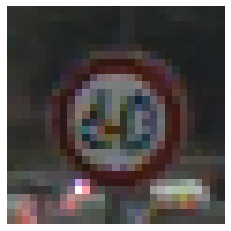

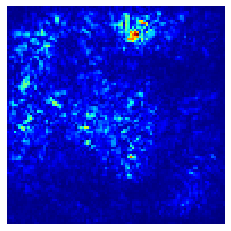

Sign class 3 misinterpreted as 42


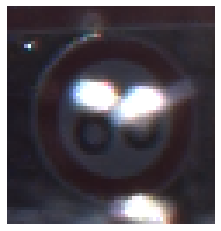

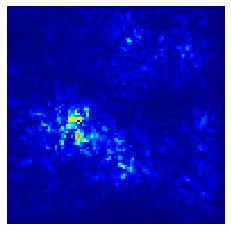

Sign class 42 correctly interpreted as 42


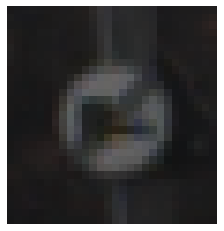

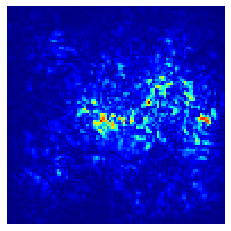

Sign class 3 correctly interpreted as 3


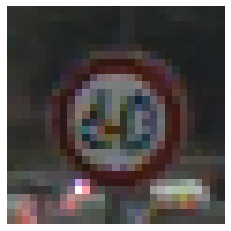

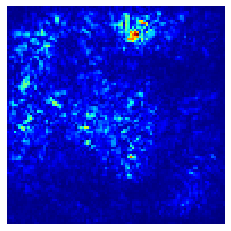

Sign class 6 misinterpreted as 42


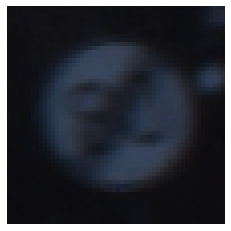

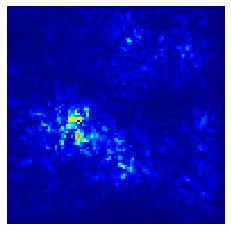

Sign class 42 correctly interpreted as 42


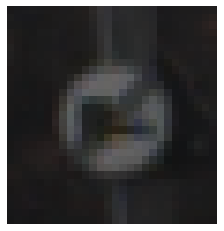

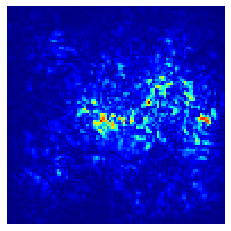

Sign class 6 correctly interpreted as 6


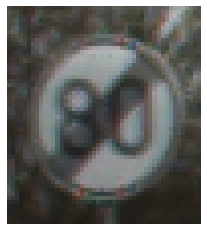

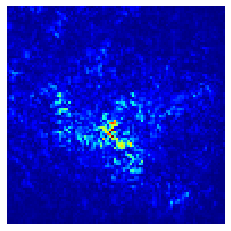

Sign class 6 misinterpreted as 39


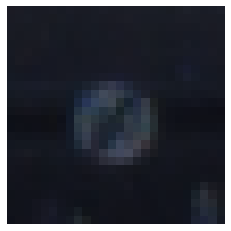

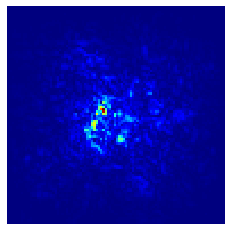

Sign class 39 correctly interpreted as 39


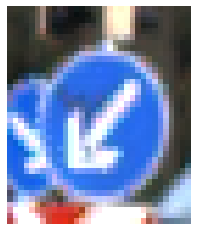

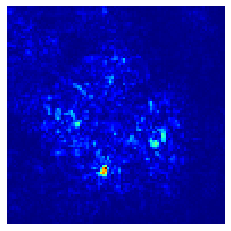

Sign class 6 correctly interpreted as 6


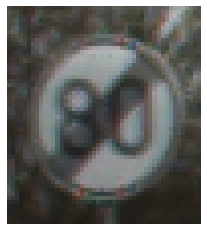

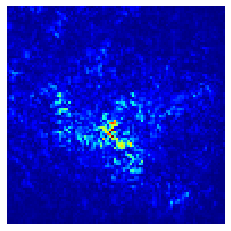

Sign class 6 misinterpreted as 20


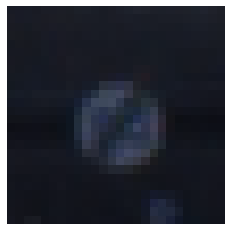

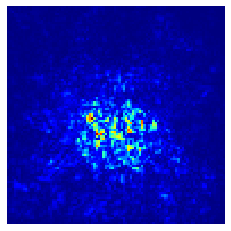

Sign class 20 correctly interpreted as 20


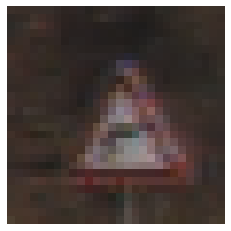

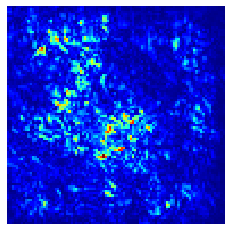

Sign class 6 correctly interpreted as 6


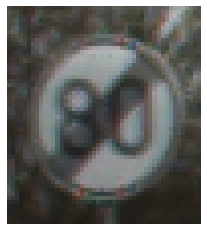

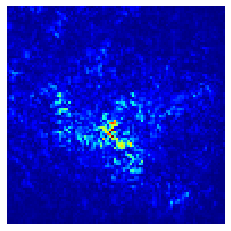

Sign class 2 misinterpreted as 1


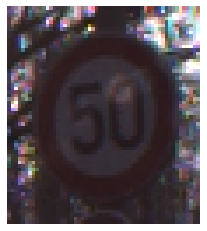

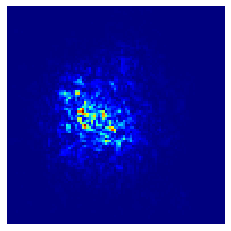

Sign class 1 correctly interpreted as 1


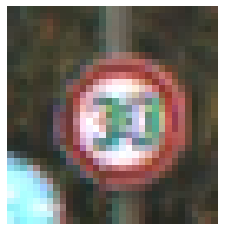

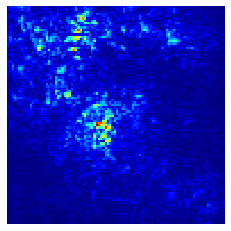

Sign class 2 correctly interpreted as 2


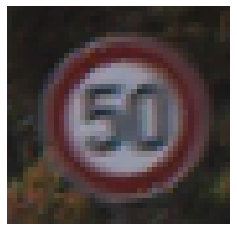

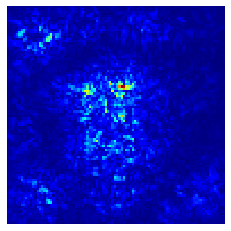

In [12]:
model_path = os.path.join(os.getcwd(), 'checkpoints', 'final-dense-2-0.9935.hdf5')
interested_classes = [2, 3, 6]
generateSaliencyFinalReport(model_path, "", interested_classes)

Accuracy: 0.9577197149643706
Sign 1 mispredicted as (5: 6)  (20: 3)  (30: 1) accuracy is 0.9861111111111112 with 710/720
Sign 2 mispredicted as (3: 14)  (5: 2)  (1: 1) accuracy is 0.9773333333333334 with 733/750
Sign 3 mispredicted as (20: 3)  (5: 2) accuracy is 0.9888888888888889 with 445/450
Sign 4 mispredicted as (20: 10)  (25: 6)  (3: 6)  (8: 2)  (40: 2)  (1: 1)  (5: 1) accuracy is 0.9575757575757575 with 632/660
Sign 5 mispredicted as (20: 3)  (3: 3)  (7: 1)  (30: 1) accuracy is 0.9873015873015873 with 622/630
Sign 6 mispredicted as (42: 16)  (5: 6)  (20: 1) accuracy is 0.8466666666666667 with 127/150
Sign 7 mispredicted as (40: 66)  (5: 14)  (38: 4)  (8: 2)  (30: 1)  (3: 1)  (15: 1)  (16: 1) accuracy is 0.8 with 360/450
Sign 8 mispredicted as (20: 17)  (3: 3)  (16: 2)  (5: 2)  (40: 2)  (38: 1)  (33: 1)  (0: 1)  (7: 1) accuracy is 0.9333333333333333 with 420/450
Sign 9 mispredicted as (20: 3)  (10: 2)  (32: 1) accuracy is 0.9875 with 474/480
Sign 10 mispredicted as (20: 17)  (13: 

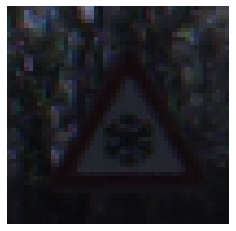

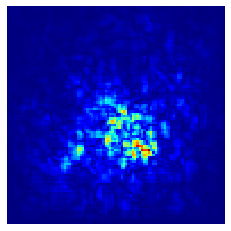

Sign class 20 correctly interpreted as 20


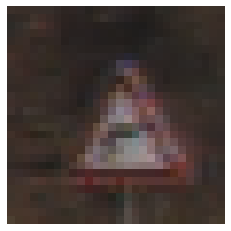

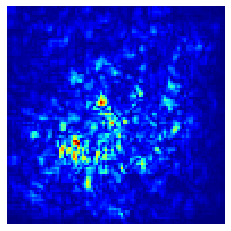

Sign class 30 correctly interpreted as 30


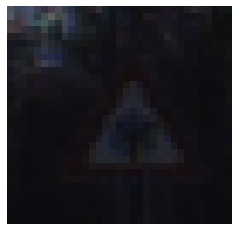

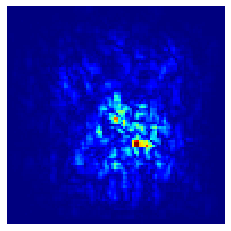

Sign class 30 misinterpreted as 28


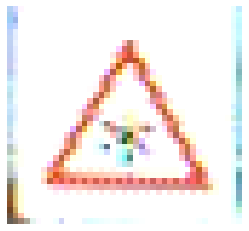

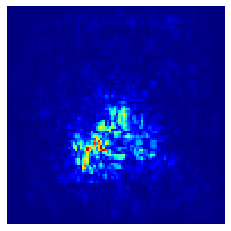

Sign class 28 correctly interpreted as 28


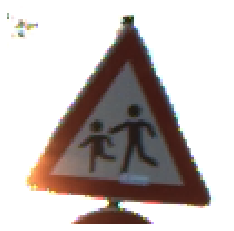

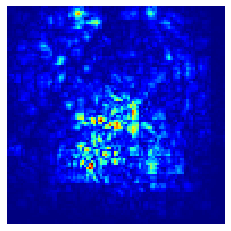

Sign class 30 correctly interpreted as 30


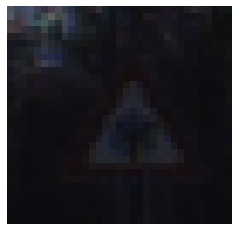

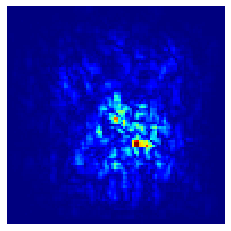

Sign class 30 misinterpreted as 5


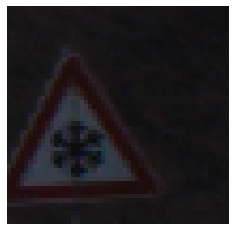

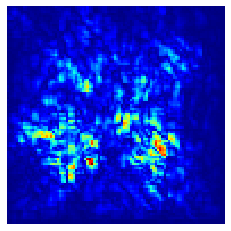

Sign class 5 correctly interpreted as 5


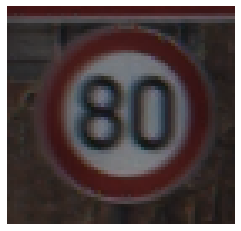

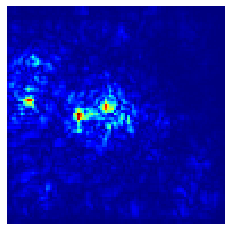

Sign class 30 correctly interpreted as 30


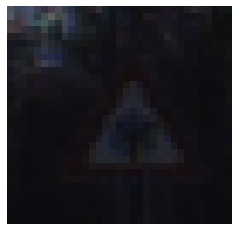

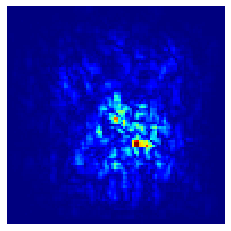

Sign class 30 misinterpreted as 31


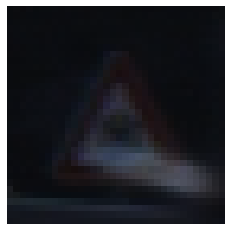

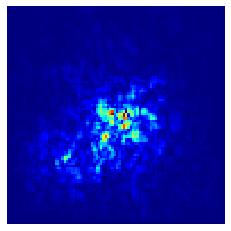

Sign class 31 correctly interpreted as 31


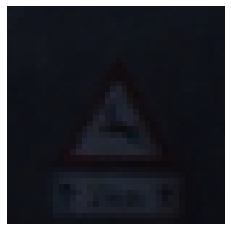

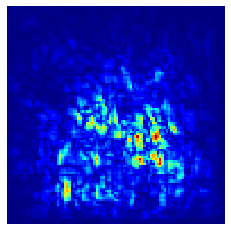

Sign class 30 correctly interpreted as 30


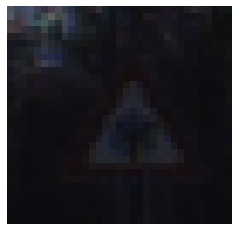

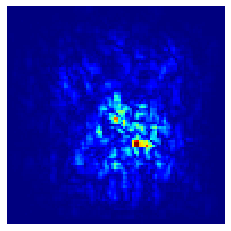

Sign class 38 misinterpreted as 20


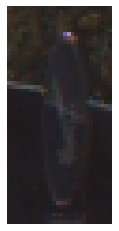

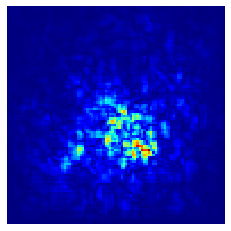

Sign class 20 correctly interpreted as 20


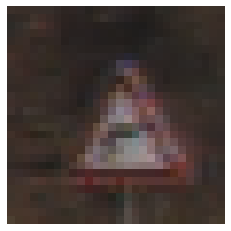

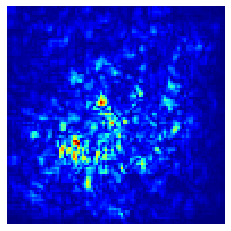

Sign class 38 correctly interpreted as 38


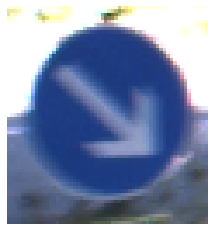

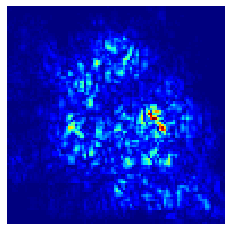

Sign class 38 misinterpreted as 40


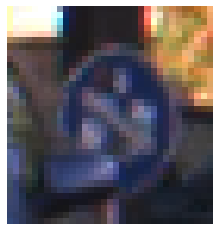

KeyboardInterrupt: 

In [17]:
model_path = "/media/exfat/cs221-project/checkpoints/resnet-final-report-imagenet-no-freeze-full-aug-30.hdf5"
interested_classes = [17, 30, 18, 15, 25, 38, 6, 18]
generateSaliencyFinalReport(model_path, "resnet", interested_classes)

# Confusion Matrix

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def getLabelText(file):
    labels = []
    content = pd.read_csv(file)
    for name in content['SignName']:
        labels.append(name)
    return labels

def showConfusionMatrix(true_labels, predicated_labels, label_text):
    cm = confusion_matrix(true_labels, predicated_labels)
    confusion_df = pd.DataFrame(cm, index=label_text, columns=label_text)
    plt.figure(figsize = (50,30))
    sns.set(font_scale=3.0)
    ax = sns.heatmap(confusion_df, annot=True, cmap = "Blues", fmt="d", annot_kws={"size": 32})
    # fix clipping
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)




Accuracy: 0.9935075217735551
Sign 2 mispredicted as (1: 5) accuracy is 0.9933333333333333 with 745/750
Sign 3 mispredicted as (5: 3)  (42: 1) accuracy is 0.9911111111111112 with 446/450
Sign 4 mispredicted as (20: 1)  (2: 1) accuracy is 0.996969696969697 with 658/660
Sign 5 mispredicted as (1: 1) accuracy is 0.9984126984126984 with 629/630
Sign 6 mispredicted as (42: 3)  (39: 3)  (20: 1) accuracy is 0.9533333333333334 with 143/150
Sign 7 mispredicted as (8: 1) accuracy is 0.9977777777777778 with 449/450
Sign 8 mispredicted as (5: 2) accuracy is 0.9955555555555555 with 448/450
Sign 11 mispredicted as (30: 2)  (20: 1) accuracy is 0.9928571428571429 with 417/420
Sign 12 mispredicted as (38: 3) accuracy is 0.9956521739130435 with 687/690
Sign 13 mispredicted as (41: 1)  (35: 1) accuracy is 0.9972222222222222 with 718/720
Sign 17 mispredicted as (13: 1) accuracy is 0.9972222222222222 with 359/360
Sign 18 mispredicted as (21: 3)  (4: 2)  (10: 1) accuracy is 0.9846153846153847 with 384/390

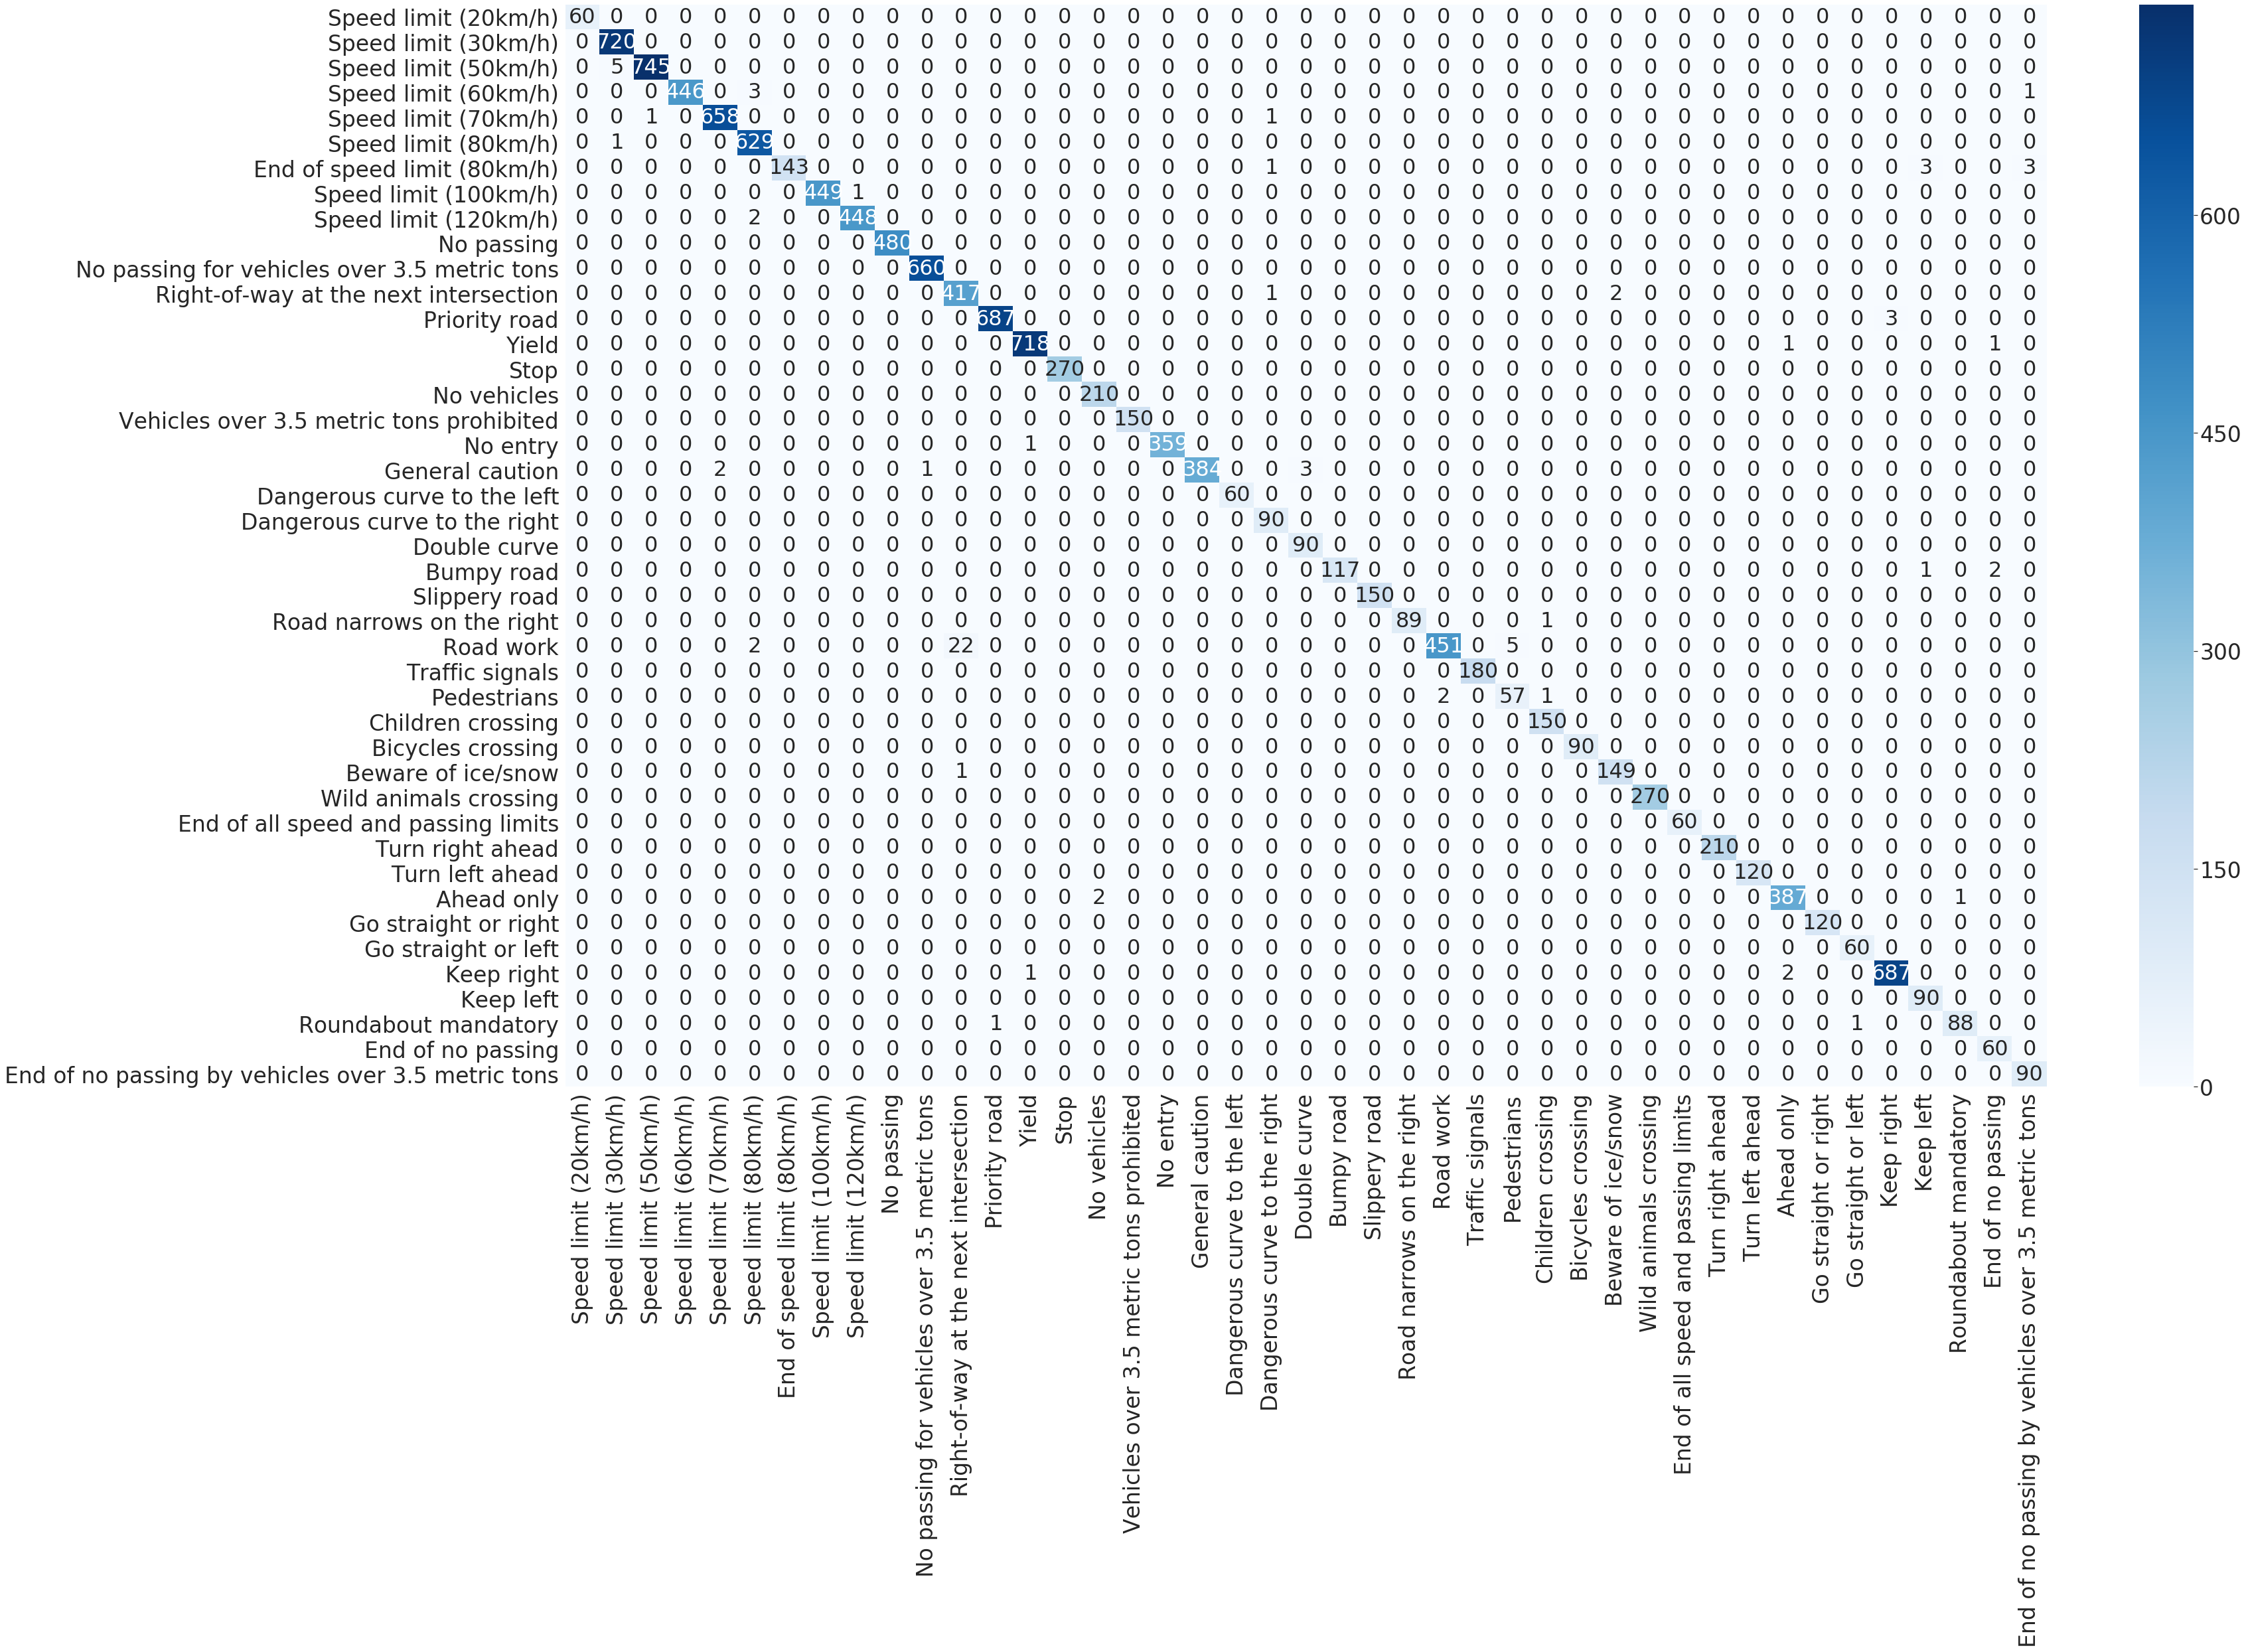

In [12]:
model_path = os.path.join(os.getcwd(), 'checkpoints', 'final-dense-2-0.9935.hdf5')
_, _, y_pred, y_true = TestModelFinalReport(model_path)
label_text = getLabelText('data/label_names.csv')
showConfusionMatrix(y_true, y_pred, label_text)

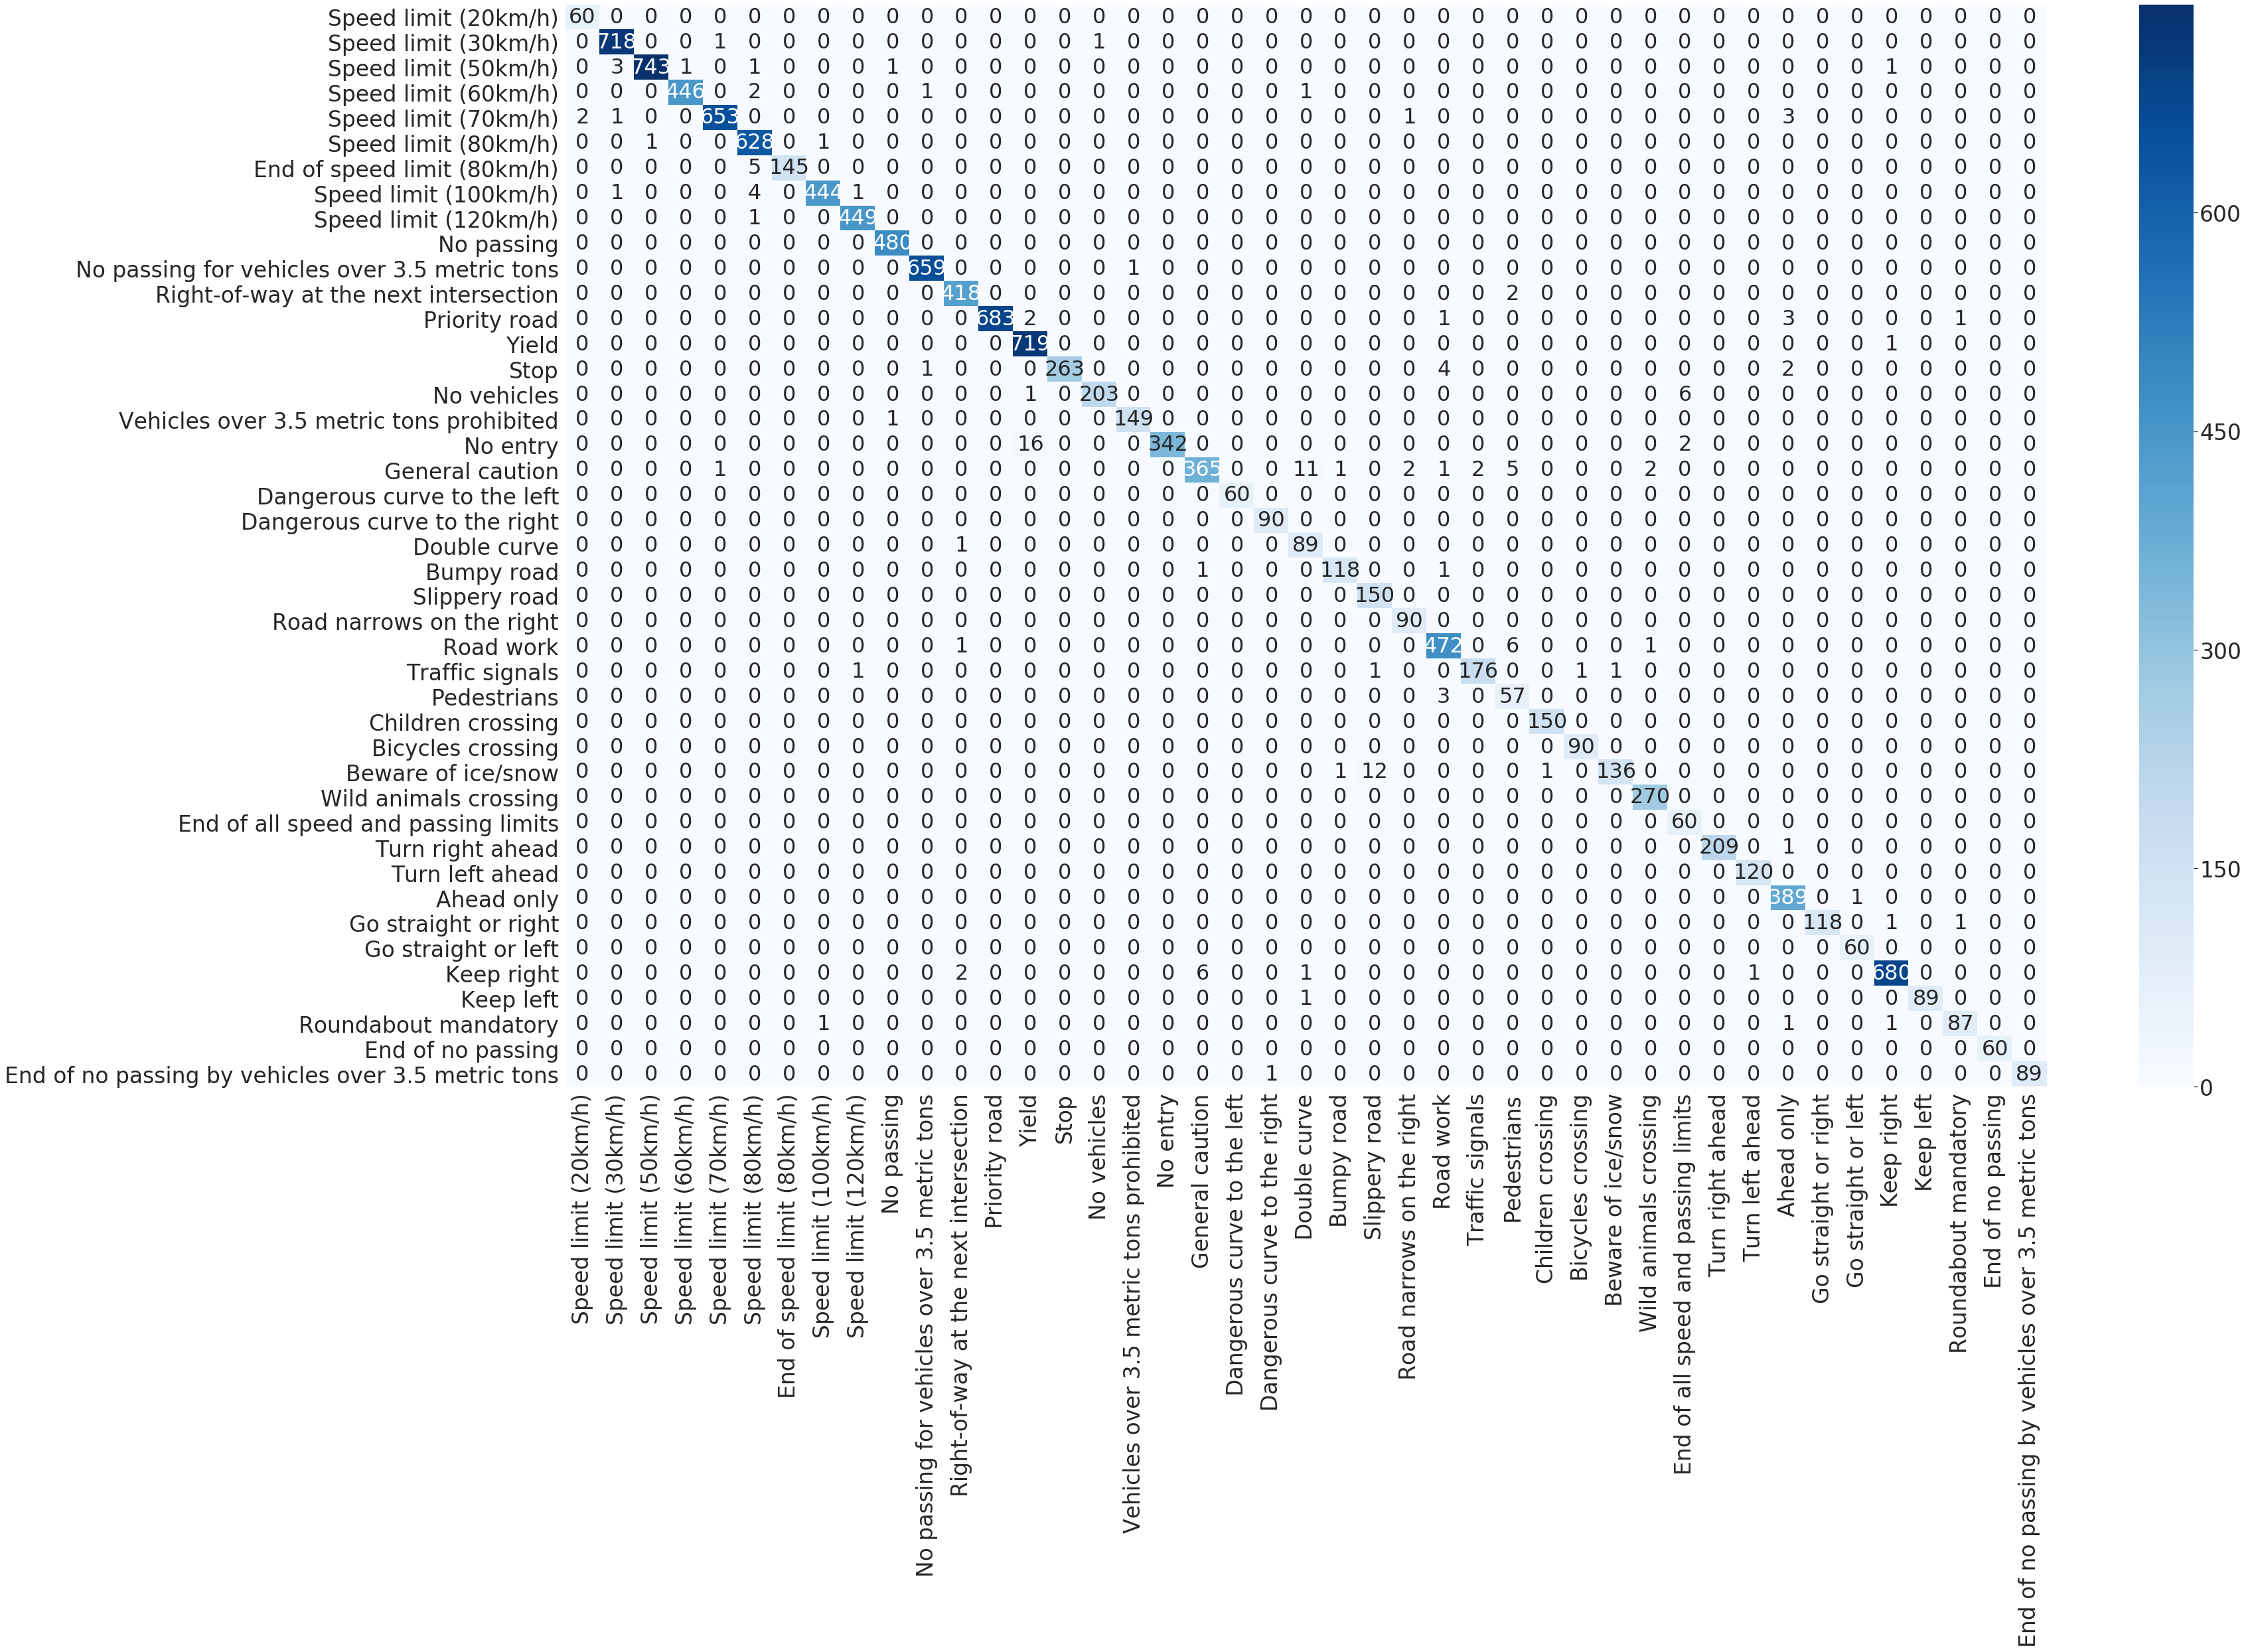

In [14]:
with open("resnet_best_y_pred.pickle", "rb") as handle:
    resnet_best_y_pred = pickle.load(handle)
with open("resnet_best_y_true.pickle", "rb") as handle:
    resnet_best_y_true = pickle.load(handle)
showConfusionMatrix(resnet_best_y_true, resnet_best_y_pred, label_text)